# Customer Segmentation <a class="tocSkip">

Ce notebook dédié à l'analyse et à la segmentation de données. Dans ce projet, nous explorons un ensemble de données transactionnelles exhaustif provenant d'un détaillant en ligne basé au Royaume-Uni et enregistré, couvrant la période du 01/12/2010 au 09/12/2011. 

L'objectif principal de cette analyse est de comprendre le comportement d'achat des clients et de segmenter ces derniers en groupes distincts afin d'améliorer les stratégies marketing et d'augmenter les ventes. 

Dans ce notebook, nous aborderons les points suivants :
- **Description des Données** : Une vue d'ensemble des différentes colonnes de notre ensemble de données, y compris les numéros de facture, les codes produit, les descriptions, les quantités, les dates des factures, les prix unitaires, les identifiants clients et les pays.
- **Analyse Exploratoire des Données** : Une analyse approfondie des données pour comprendre leur structure, leurs tendances et leurs relations.
- **Prétraitement des Données** : Nettoyage et préparation des données pour les rendre aptes à l'analyse et à la modélisation.
- **Segmentation des Clients** : Utilisation des l'algorithme de clustering pour segmenter les clients en groupes distincts en fonction de leur comportement d'achat.
- **Modélisation et Recommandation** : Développement d'un modèle prédictif pour anticiper les futurs achats des clients et création d'un système de recommandation pour suggérer des produits pertinents à chaque segment de clients.

# Configuration et Initialisation

## Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime, nltk, warnings
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loadin the dataset

In [2]:
data=pd.read_excel("data/Online-retail.xlsx")

In [3]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
print("Number of rows in dataset is: ", data.shape[0])
print("Number of columns in dataset is: ", data.shape[1])

Number of rows in dataset is:  541909
Number of columns in dataset is:  8


In [5]:
data.describe()
#we observe that Quantity has a neagative value that we should to drop it 

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

In [6]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
#Satatistics for numerical value 
data.describe().T

count                           mean                  min  \
Quantity     541909.0                        9.55225             -80995.0   
InvoiceDate    541909  2011-07-04 13:34:57.156386048  2010-12-01 08:26:00   
UnitPrice    541909.0                       4.611114            -11062.06   
CustomerID   406829.0                    15287.69057              12346.0   

                             25%                  50%                  75%  \
Quantity                     1.0                  3.0                 10.0   
InvoiceDate  2011-03-28 11:34:00  2011-07-19 17:17:00  2011-10-19 11:27:00   
UnitPrice                   1.25                 2.08                 4.13   
CustomerID               13953.0              15152.0              16791.0   

                             max          std  
Quantity                 80995.0   218.081158  
InvoiceDate  2011-12-09 12:50:00          NaN  
UnitPrice                38970.0    96.759853  
CustomerID               18287.0  1713.600303

<ul>
    <li><b>Quantity</b>: the quantity has a wide range , with a minimum value of -80995.0 and nax value 80995.0 the negative value indicates returned or cancelled orders . The large std could be indicates  the presence of outliers :the presence of extremely negative and large positive values   </li>
</ul>

In [8]:
#statistics for categorical value 
data.describe(include='object').T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
Country      541909     38                      United Kingdom  495478

<ul>
    <li><b>Description</b> : there are 4223  unique product descriptions , the most frequent product
    description is <b>WHITE HANGING HEART T-LIGHT HOLDE</b> appering 2369 </li>
    <li><b>Country</b> : the transactions come from 38 diffrent countries originating from the United Kingdom</li>
    <li><b>StockCode</b> : there are 4070  unique stock codes representing diffrenets product , the most frequent stock <b>85123A </B> </li>
    <li><b>InvoiceNo</b> : There are 25900 unique invoice numbers, indicating 25900 separate transactions.The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items. </li>
</ul>

## Handling Missing Value

In [9]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

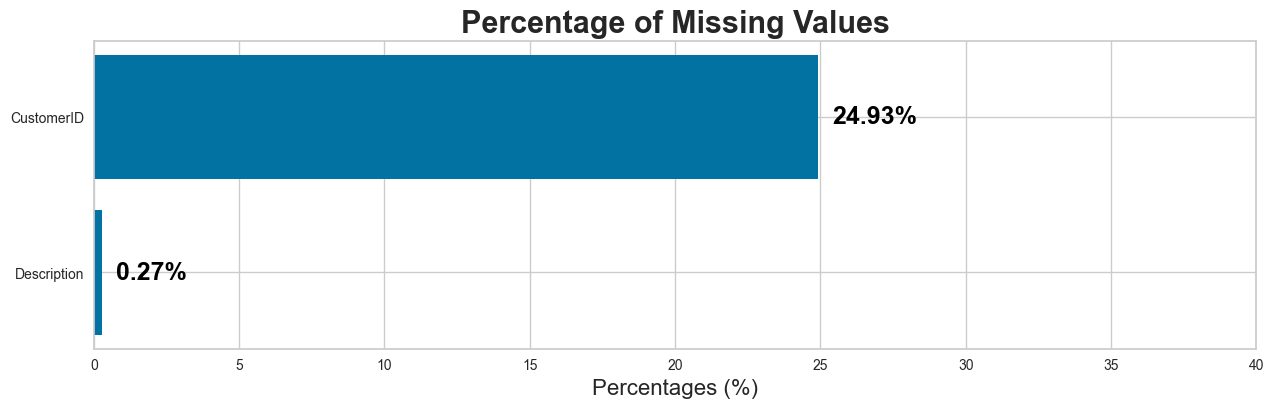

In [10]:
# Calculating the percentage of missing values for each column
missing_data = data.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / data.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


In [11]:
#data cleaning 
#dropping rows having missing values
data = data.dropna(subset=['CustomerID', 'Description'])
data.shape

(406829, 8)

In [12]:
data.isnull().sum().sum()

0

In [13]:
#Duplicates rows
duplicates_rows =data[data.duplicated(keep=False)]
data_duplicates=duplicates_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
data_duplicates.head(7)

InvoiceNo StockCode                       Description  Quantity  \
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
494 2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
517 2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
485 2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
539 2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
489 2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
527 2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
521 2010-12-01 11:45:00       2.95     17908.0  United Kingdom

In [14]:
print(data_duplicates.shape)
print(f'the sum of duplicates rows :{data.duplicated().sum()}')

(10062, 8)
the sum of duplicates rows :5225


In [15]:
#drop duplicates rows 
data.drop_duplicates(inplace=True)

In [16]:
data.shape

(401604, 8)

## Treating Canceled Transactions 

In [17]:
#the cancelled  transaction "InvoiceNO" start with 'C'
#We create a coulumn that indicates the transaction status 
data['Transaction_Status'] = np.where(data['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = data[data['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['CustomerID','InvoiceDate'], axis=1)

Quantity     UnitPrice
count   8872.000000   8872.000000
mean     -30.774910     18.899512
min   -80995.000000      0.010000
25%       -6.000000      1.450000
50%       -2.000000      2.950000
75%       -1.000000      4.950000
max       -1.000000  38970.000000
std     1172.249902    445.190864

<ul>
    <li>We observed that the negative values of UnitPrice disappeared. Therefore, we concluded that these values were part of the cancelled transactions.</li>
</ul>

In [18]:
#Percentage of cancelled transactions
canc_percentage=(cancelled_transactions.shape[0]/data.shape[0])*100
print(f"The percentage of cancelled transactions in the dataset is: {canc_percentage:.2f}%")


The percentage of cancelled transactions in the dataset is: 2.21%


## Correcting StockCode Anomalies

In [19]:
Stock_code=data['StockCode'].nunique()
Stock_code

3684

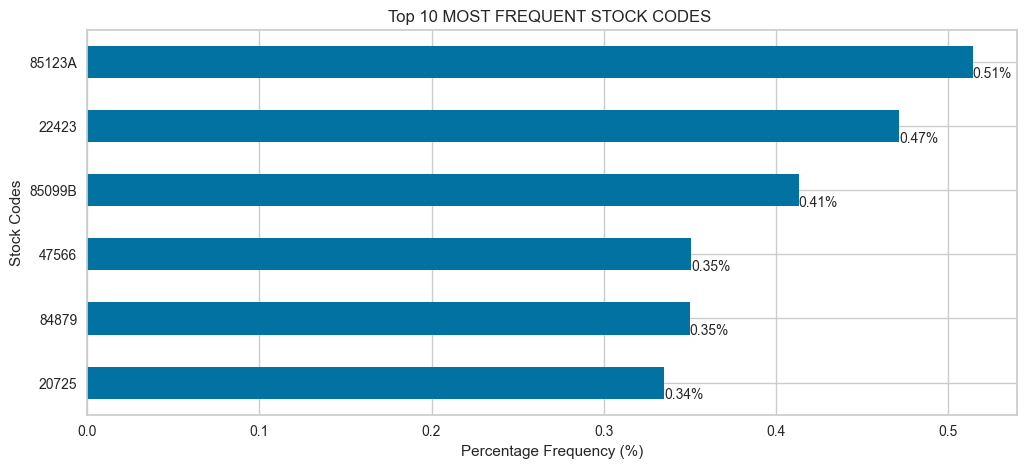

In [20]:
top_10_Stock_codes=data['StockCode'].value_counts(normalize=True).head(6)*100
plt.figure(figsize=(12,5))
top_10_Stock_codes.plot(kind='barh')
#adding the percentage frequency on the bars 
for index, value in enumerate(top_10_Stock_codes):
    plt.text(value,index+0.25,f'{value:.2f}%',fontsize=10)


plt.title('Top 10 MOST FREQUENT STOCK CODES ')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

## Some inferences 
the figure  bellow offer insights into the popular products or categories that are frequently purshased by customers . this information may help us to identify distinct customer clusters , with preferences for selling diffrent types of products 

According to the definition of the feature <b>StockCode</b> it is expected to be a 5-digit integral number that is uniquely assigned to each distinct product. However, upon observation, we have identified anomalies in this column that require treatment or resolution. 

In [ ]:
stock_numbers=data['StockCode'].unique().tolist()
#stock_numbers

In [ ]:
for item in stock_numbers:
    if isinstance(item,str):
       # print(item)

In [23]:
unique_stock_codes=data['StockCode'].unique()
numeric_count_unique_codes=pd.Series(unique_stock_codes).apply(lambda x:sum(c.isdigit() for c in str(x))).value_counts()
print("Values count of numeric charcters")
print(numeric_count_unique_codes)


Values count of numeric charcters
5    3676
0       7
1       1
Name: count, dtype: int64


### Some inferences 

The majority pof these stock codes contains exactly 5 numeric charcters , wich seems to be the standard format for representing product codes in this dataset , but there  a few anomalies  codes contain non numeric characters : 7 codes is A String Codes  1 stock code contain only 1 numeric character 

In [24]:
## let's find the 7 anomalies codes 
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [25]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (data['StockCode'].isin(anomalous_stock_codes).sum() / len(data)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [26]:
#  remove this  rows contain anomalies dtock codes 
data=data[~data['StockCode'].isin(anomalous_stock_codes)]
data.shape[0]

399689

# Cleaning Description Column 

Text(0.5, 1.0, 'Top 30 Most Frequent Descriptions')

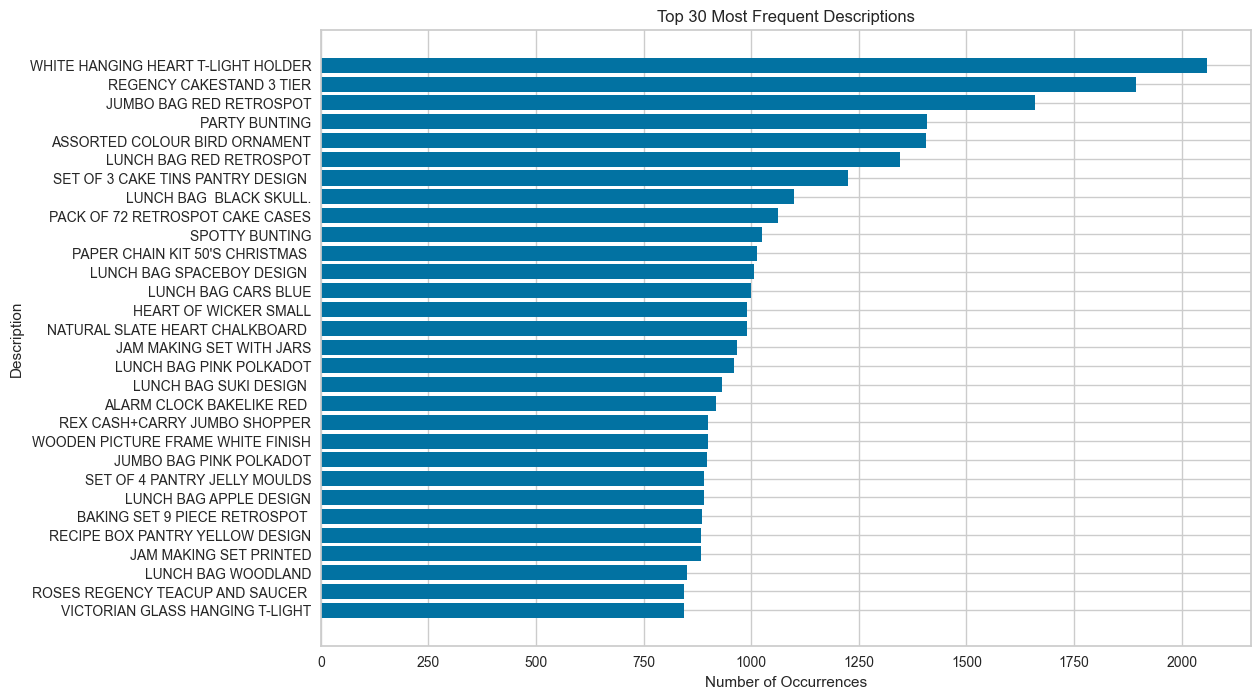

In [31]:
# Calculate the occurrence of each unique description and sort them
description_counts = data['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1])

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot

In [32]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [33]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:'Description'})


In [34]:
df_produits

Description
0      WHITE HANGING HEART T-LIGHT HOLDER
1                     WHITE METAL LANTERN
2          CREAM CUPID HEARTS COAT HANGER
3     KNITTED UNION FLAG HOT WATER BOTTLE
4          RED WOOLLY HOTTIE WHITE HEART.
...                                   ...
3883            LETTER "W" BLING KEY RING
3884            LETTER "Z" BLING KEY RING
3885       PINK CRYSTAL SKULL PHONE CHARM
3886   CREAM HANGING HEART T-LIGHT HOLDER
3887          PAPER CRAFT , LITTLE BIRDIE

[3888 rows x 1 columns]

In [35]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1479


In [36]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

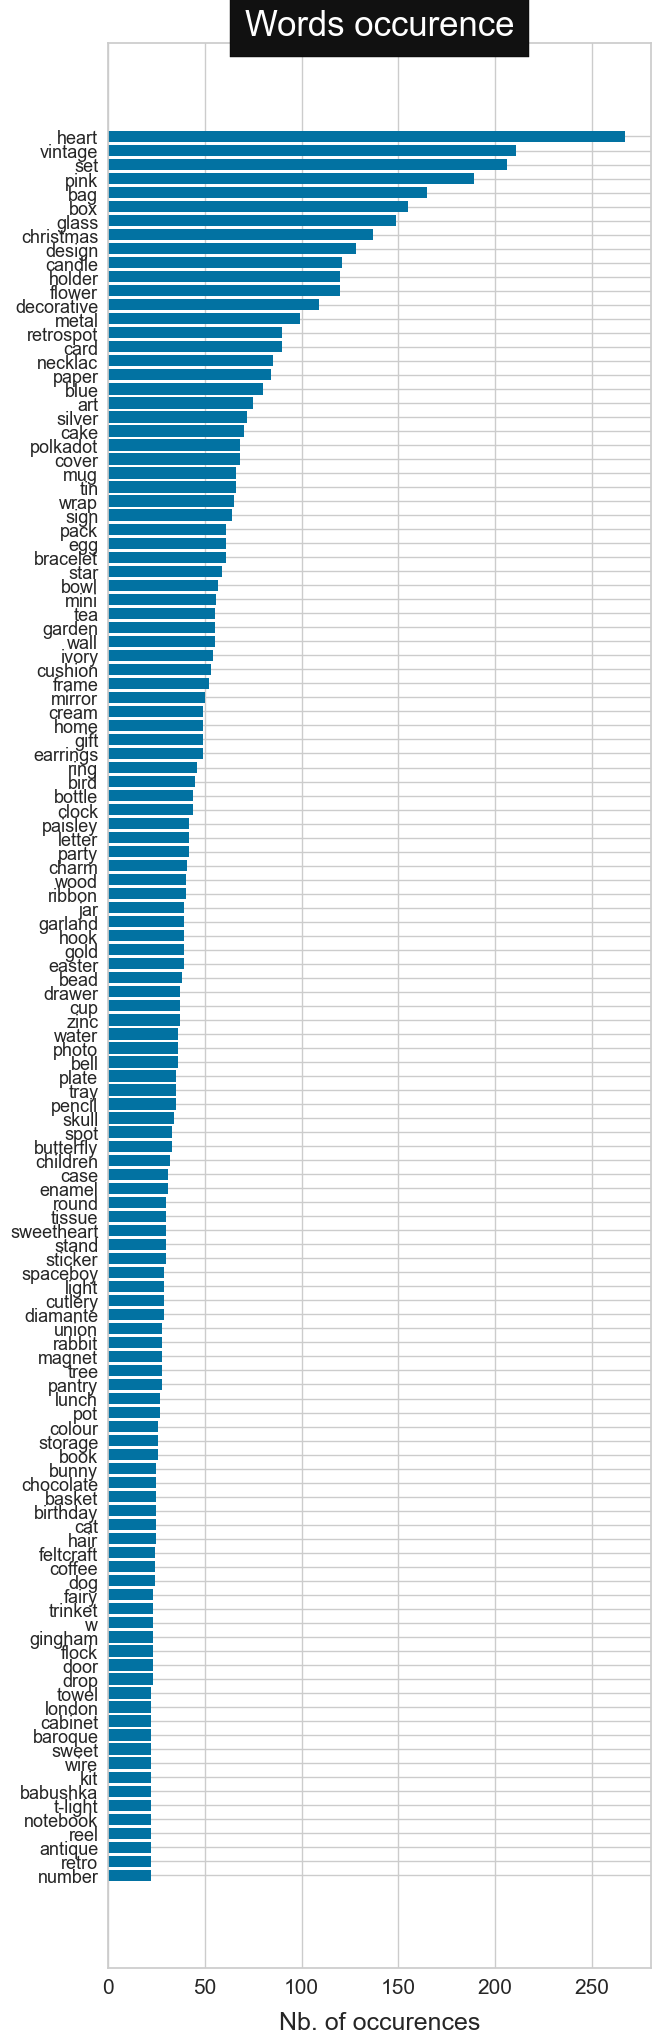

In [37]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

## Inferences on Descriptions:
<ul><li>>The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
All the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.</li>
<li></li>

In [38]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = data['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [39]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]
# Remove rows with service-related information in the description
data = data[~data['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
data['Description'] = data['Description'].str.upper()

In [40]:
data.shape[0]

399606

In [41]:
data.head(4)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   

          InvoiceDate  UnitPrice  CustomerID         Country  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

  Transaction_Status  
0          Completed  
1          Completed  
2          Completed  
3          Completed

# Treating Zero Unit Prices

In [42]:
data['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [43]:
# see the number of   UnitPrice that have  value  0 and quantity  
data[data['UnitPrice']==0].describe()[['Quantity']]

Quantity
count     33.000000
mean     420.515152
min        1.000000
25%        2.000000
50%       11.000000
75%       36.000000
max    12540.000000
std     2176.713608

In [44]:
data=data[data['UnitPrice']>0] ##drop the product that have a unit price equal to 0

In [45]:
data.shape[0]

399573

## Outlier Treatment

In [46]:
data.reset_index(drop=True, inplace=True)
data.shape[0]

399573

# feature Engeneering 
## RFM feature

<b>RFM</b> is a method used for anlysing costumer value ans segmentation base .It is an acronym that stands for :
<ul>
    <li> Recency (R) : this metric indicates how recently a customer has made a purshase. A lower recency value means the customer has purshased more recently , indicating higher engagement with  the brand </li>
    <li> Frequency (F): this  metric signifies how often a customer makes a purshase within  a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.</li>
</ul>

In [47]:
#Add feature DaysSinceLastPurchas :this feature represents the number of days that have passed since the customers last purshase
#lower value indicates that the customer has purshased recently , implying a higher engagemnt level with the business 

#convert Invoice Date to datetime type 
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

#convert Invoice Date to date time and extrcat only the date 
data['InvoiceDay']=data['InvoiceDate'].dt.date

#Find the most recent purshase date for eash customer
customer_data=data.groupby('CustomerID')['InvoiceDay'].max().reset_index()
customer_data.head()


CustomerID  InvoiceDay
0     12346.0  2011-01-18
1     12347.0  2011-12-07
2     12348.0  2011-09-25
3     12349.0  2011-11-21
4     12350.0  2011-02-02

In [48]:
customer_data.shape

(4362, 2)

In [49]:
# Find the most recent date in the entire dataset
most_recent_date=data['InvoiceDay'].max()
#Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [50]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase
0     12346.0                       325
1     12347.0                         2
2     12348.0                        75
3     12349.0                        18
4     12350.0                       310

## Frequency 

<ul>
    <li> <b>Total transactions </b>: This feature represents the total number of transactions made by a customer. it helps in understanding the engagement level of a customer with the retailer </li>
    <li><b>Total Products Purchased </b>: his feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.</li>
</ul>

In [51]:
# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_products_purchased = data[data['Quantity'] > 0].groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  
0                     74215  
1                      2458  
2                      2332  
3                       630  
4                       196

In [52]:
customer_data.describe()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
count   4334.000000               4334.000000         4334.000000   
mean   15299.251731                 90.358791            5.018459   
std     1721.994109                 99.484595            9.106728   
min    12346.000000                  0.000000            1.000000   
25%    13812.250000                 16.000000            1.000000   
50%    15297.500000                 49.000000            3.000000   
75%    16778.750000                140.000000            5.000000   
max    18287.000000                373.000000          242.000000   

       Total_Products_Purchased  
count               4334.000000  
mean                1186.363867  
std                 5040.618625  
min                    1.000000  
25%                  159.250000  
50%                  377.500000  
75%                  989.750000  
max               196844.000000

## Monetary 
<ul>
    <li><b>Total spend</b> :This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business. </li>
    <li><b>Average Transaction Value </b>: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.
    </li>
</ul>

In [53]:
# Calculate the total spend for positive quantities only
data['Total_Spend'] = data['UnitPrice'] * data[data['Quantity'] > 0]['Quantity']
total_spend = data.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  
0                     74215     77183.60               38591.800000  
1                      2458      4310.00                 615.714286  
2                      2332      1437.24                 359.310000  
3                       630      1457.55                1457.550000  
4                       196       294.40                 294.400000

In [54]:
customer_data.describe()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
count   4334.000000               4334.000000         4334.000000   
mean   15299.251731                 90.358791            5.018459   
std     1721.994109                 99.484595            9.106728   
min    12346.000000                  0.000000            1.000000   
25%    13812.250000                 16.000000            1.000000   
50%    15297.500000                 49.000000            3.000000   
75%    16778.750000                140.000000            5.000000   
max    18287.000000                373.000000          242.000000   

       Total_Products_Purchased    Total_Spend  Average_Transaction_Value  
count               4334.000000    4334.000000                4334.000000  
mean                1186.363867    2015.690042                 352.011790  
std                 5040.618625    8903.655720                1109.881250  
min                    1.000000       3.750000                   3.100000  
25%                  159.250000     304.240000                 156.814375  
50%                  377.500000     661.420000                 242.128205  
75%                  989.750000    1631.622500                 372.744500  
max               196844.000000  279138.020000               56157.500000

# Product diversity
we add the feature unique products purshased :
the feature represents the number of distinct products bought by a customer 
A  higher value indicates that the customer has a diverse taste or preference 
buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [55]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215     77183.60               38591.800000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  
0                          1  
1                        103  
2                         21  
3                         72  
4                         16

# Behavioral Freatures 
<ul>
    <li>Average Day Between Purchases</li>
    <li>Favourite Day Shopping </li>
    <li>Favourite Hour Shopping </li>
</ul>


In [56]:
# Extract day of week and hour from InvoiceDate
data['Day_Of_Week'] = data['InvoiceDate'].dt.dayofweek
data['Hour'] = data['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = data.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = data.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215     77183.60               38591.800000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  
0    10  
1    14  
2    19  
3     9  
4    16

# Geographic  features 
add Country 

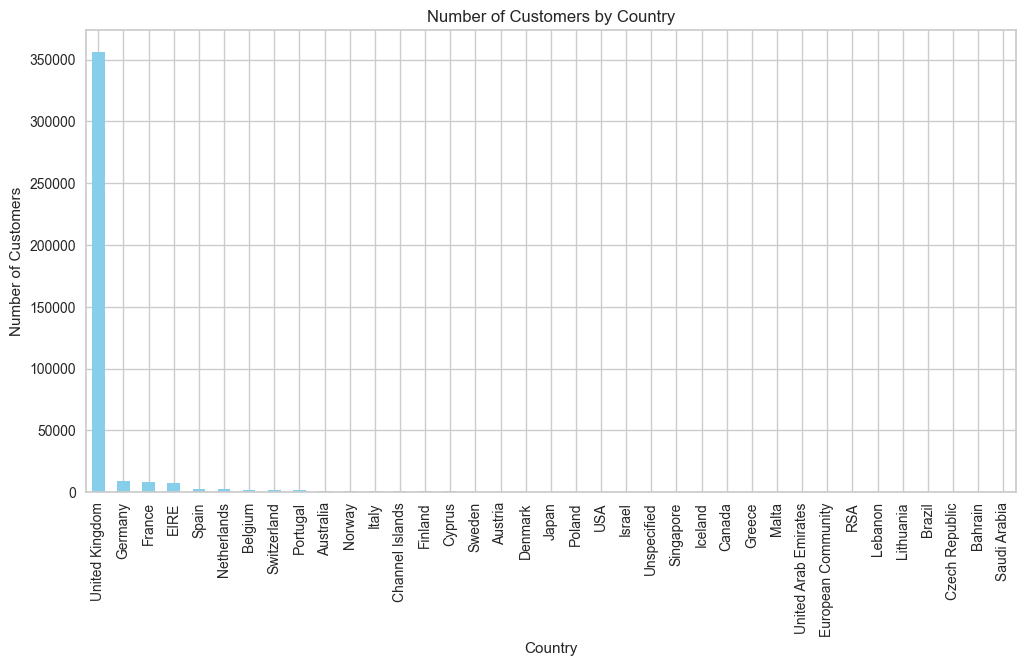

In [57]:
# Compter le nombre de clients pour chaque pays
customer_counts = data['Country'].value_counts()

# Créer un bar plot
plt.figure(figsize=(12, 6))
customer_counts.plot(kind='bar', color='skyblue')

# Définir le titre et les labels
plt.title('Number of Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')

# Afficher le plot
plt.show()

In [58]:
customer_counts_by_country_df = customer_counts.to_frame()
print(customer_counts_by_country_df)


                       count
Country                     
United Kingdom        356008
Germany                 9079
France                  8152
EIRE                    7368
Spain                   2462
Netherlands             2326
Belgium                 1971
Switzerland             1843
Portugal                1427
Australia               1253
Norway                  1059
Italy                    783
Channel Islands          752
Finland                  653
Cyprus                   608
Sweden                   436
Austria                  387
Denmark                  375
Japan                    355
Poland                   336
USA                      291
Israel                   247
Unspecified              241
Singapore                215
Iceland                  182
Canada                   150
Greece                   142
Malta                    123
United Arab Emirates      67
European Community        58
RSA                       57
Lebanon                   45
Lithuania     

In [59]:
#the most custoomer from Uk thus ;
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = data.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215     77183.60               38591.800000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  
0    10      1  
1    14      0  
2    19      0  
3     9      0  
4    16      0

# Concellation Insights
<ul>
    <li>Cancellation Frequency </li>
    <li>Cancellation Rate</li>
</ul>

In [60]:

# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = data[data['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215     77183.60               38591.800000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  
0    10      1                     1.0                0.5  
1    14      0                     0.0                0.0  
2    19      0                     0.0                0.0  
3     9      0                     0.0                0.0  
4    16      0                     0.0                0.0

#  Seasonality & Trends
<ul>
    <li>Monthly_Spending_Mean</li>
    <li>Monthly_Spending_Std</li>
    <li>Spending_Trend</li>
</ul>

In [61]:
from scipy.stats import linregress

# Extract month and year from InvoiceDate
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = data.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215     77183.60               38591.800000   
1                      2458      4310.00                 615.714286   
2                      2332      1437.24                 359.310000   
3                       630      1457.55                1457.550000   
4                       196       294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                        0.000000            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                        0.000000            0   
4                         16                        0.000000            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                     1.0                0.5   
1    14      0                     0.0                0.0   
2    19      0                     0.0                0.0   
3     9      0                     0.0                0.0   
4    16      0                     0.0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0           77183.600000              0.000000        0.000000  
1             615.714286            341.070789        4.486071  
2             359.310000            203.875689     -100.884000  
3            1457.550000              0.000000        0.000000  
4             294.400000              0.000000        0.000000

In [62]:
customer_data.shape

(4265, 16)

# DATASET 

In [63]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [64]:
#customer_data.to_csv("data/customer_data.csv",index=False)

In [65]:
customer_data.head(10)


CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12346.0                       325                   2   
1    12347.0                         2                   7   
2    12348.0                        75                   4   
3    12349.0                        18                   1   
4    12350.0                       310                   1   
5    12352.0                        36                   8   
6    12353.0                       204                   1   
7    12354.0                       232                   1   
8    12355.0                       214                   1   
9    12356.0                        22                   3   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215      77183.6                    38591.8   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   
5                       526      1385.74                   173.2175   
6                        20         89.0                       89.0   
7                       530       1079.4                     1079.4   
8                       240        459.4                      459.4   
9                      1573      2487.43                 829.143333   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   
5                         57                         3.13253            1   
6                          4                             0.0            3   
7                         58                             0.0            3   
8                         13                             0.0            0   
9                         52                        5.315789            1   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   
5    14      0                       1              0.125   
6    17      0                       0                0.0   
7    13      0                       0                0.0   
8    13      0                       0                0.0   
9     9      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0                77183.6                   0.0             0.0  
1             615.714286            341.070789        4.486071  
2                 359.31            203.875689        -100.884  
3                1457.55                   0.0             0.0  
4                  294.4                   0.0             0.0  
5                346.435            120.042154          -2.682  
6                   89.0                   0.0             0.0  
7                 1079.4                   0.0             0.0  
8                  459.4                   0.0             0.0  
9             829.143333            991.462585        -944.635

In [66]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4265 non-null   string 
 1   Days_Since_Last_Purchase        4265 non-null   Int64  
 2   Total_Transactions              4265 non-null   Int64  
 3   Total_Products_Purchased        4265 non-null   Int64  
 4   Total_Spend                     4265 non-null   Float64
 5   Average_Transaction_Value       4265 non-null   Float64
 6   Unique_Products_Purchased       4265 non-null   Int64  
 7   Average_Days_Between_Purchases  4265 non-null   Float64
 8   Day_Of_Week                     4265 non-null   Int32  
 9   Hour                            4265 non-null   Int32  
 10  Is_UK                           4265 non-null   Int64  
 11  Cancellation_Frequency          4265 non-null   Int64  
 12  Cancellation_Rate               42

# Outlier Detection and Treatment 

In [67]:
#use the algorithme of isolation Forest 
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12346.0                       325                   2   
1    12347.0                         2                   7   
2    12348.0                        75                   4   
3    12349.0                        18                   1   
4    12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                     74215      77183.6                    38591.8   
1                      2458       4310.0                 615.714286   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        103                        2.016575            1   
2                         21                       10.884615            3   
3                         72                             0.0            0   
4                         16                             0.0            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    10      1                       1                0.5   
1    14      0                       0                0.0   
2    19      0                       0                0.0   
3     9      0                       0                0.0   
4    16      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
0                77183.6                   0.0             0.0   
1             615.714286            341.070789        4.486071   
2                 359.31            203.875689        -100.884   
3                1457.55                   0.0             0.0   
4                  294.4                   0.0             0.0   

   Outlier_Scores  Is_Outlier  
0              -1           1  
1               1           0  
2               1           0  
3               1           0  
4               1           0

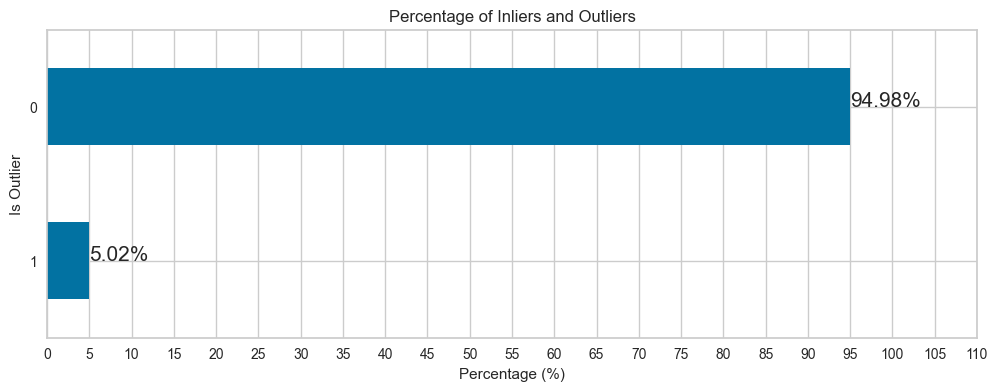

In [68]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

##  Inference
the 5% of customer has identofies as outlier but this amout of percentage seems to be a resonable propostion, not hight to lose significamnt amout of data

In [69]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [70]:
customer_data_cleaned.shape[0]

4051

In [71]:
customer_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4051 entries, 0 to 4050
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4051 non-null   string 
 1   Days_Since_Last_Purchase        4051 non-null   Int64  
 2   Total_Transactions              4051 non-null   Int64  
 3   Total_Products_Purchased        4051 non-null   Int64  
 4   Total_Spend                     4051 non-null   Float64
 5   Average_Transaction_Value       4051 non-null   Float64
 6   Unique_Products_Purchased       4051 non-null   Int64  
 7   Average_Days_Between_Purchases  4051 non-null   Float64
 8   Day_Of_Week                     4051 non-null   Int32  
 9   Hour                            4051 non-null   Int32  
 10  Is_UK                           4051 non-null   Int64  
 11  Cancellation_Frequency          4051 non-null   Int64  
 12  Cancellation_Rate               40

In [72]:
customer_data_cleaned.describe()

Days_Since_Last_Purchase  Total_Transactions  Total_Products_Purchased  \
count                    4051.0              4051.0                    4051.0   
mean                  91.673414            3.954579                669.878055   
std                   98.732797            3.964959                829.833339   
min                         0.0                 1.0                       2.0   
25%                        17.0                 1.0                     157.5   
50%                        51.0                 2.0                     355.0   
75%                       142.0                 5.0                     860.0   
max                       373.0                39.0                    9322.0   

       Total_Spend  Average_Transaction_Value  Unique_Products_Purchased  \
count       4051.0                     4051.0                     4051.0   
mean   1108.860284                 293.575391                  55.017033   
std    1275.761146                 219.493071                  59.867801   
min            6.2                        3.1                        1.0   
25%         301.52                   155.7725                       16.0   
50%          632.0                 236.073333                       34.0   
75%        1426.67                 359.241429                       73.0   
max       10464.85                    2062.06                      579.0   

       Average_Days_Between_Purchases  Day_Of_Week      Hour     Is_UK  \
count                          4051.0       4051.0    4051.0    4051.0   
mean                         3.372656     2.556406   12.5137  0.911874   
std                         10.678782     1.862022  2.306833  0.283514   
min                               0.0          0.0       7.0       0.0   
25%                               0.0          1.0      11.0       1.0   
50%                          1.240741          2.0      12.0       1.0   
75%                          3.196386          4.0      14.0       1.0   
max                             309.0          6.0      20.0       1.0   

       Cancellation_Frequency  Cancellation_Rate  Monthly_Spending_Mean  \
count                  4051.0             4051.0                 4051.0   
mean                 0.562083           0.262184             365.301372   
std                  1.054694           0.614981             285.280675   
min                       0.0                0.0                    6.2   
25%                       0.0                0.0               183.7475   
50%                       0.0                0.0                 303.43   
75%                       1.0               0.25                  453.5   
max                      10.0                6.0                6083.64   

       Monthly_Spending_Std  Spending_Trend  
count                4051.0          4051.0  
mean             122.318492      -15.512573  
std              171.909557      175.931528  
min                     0.0        -1595.48  
25%                     0.0         -24.945  
50%               57.188165             0.0  
75%               182.70891          12.391  
max             1539.696732         2177.46

## Correlation Analysis

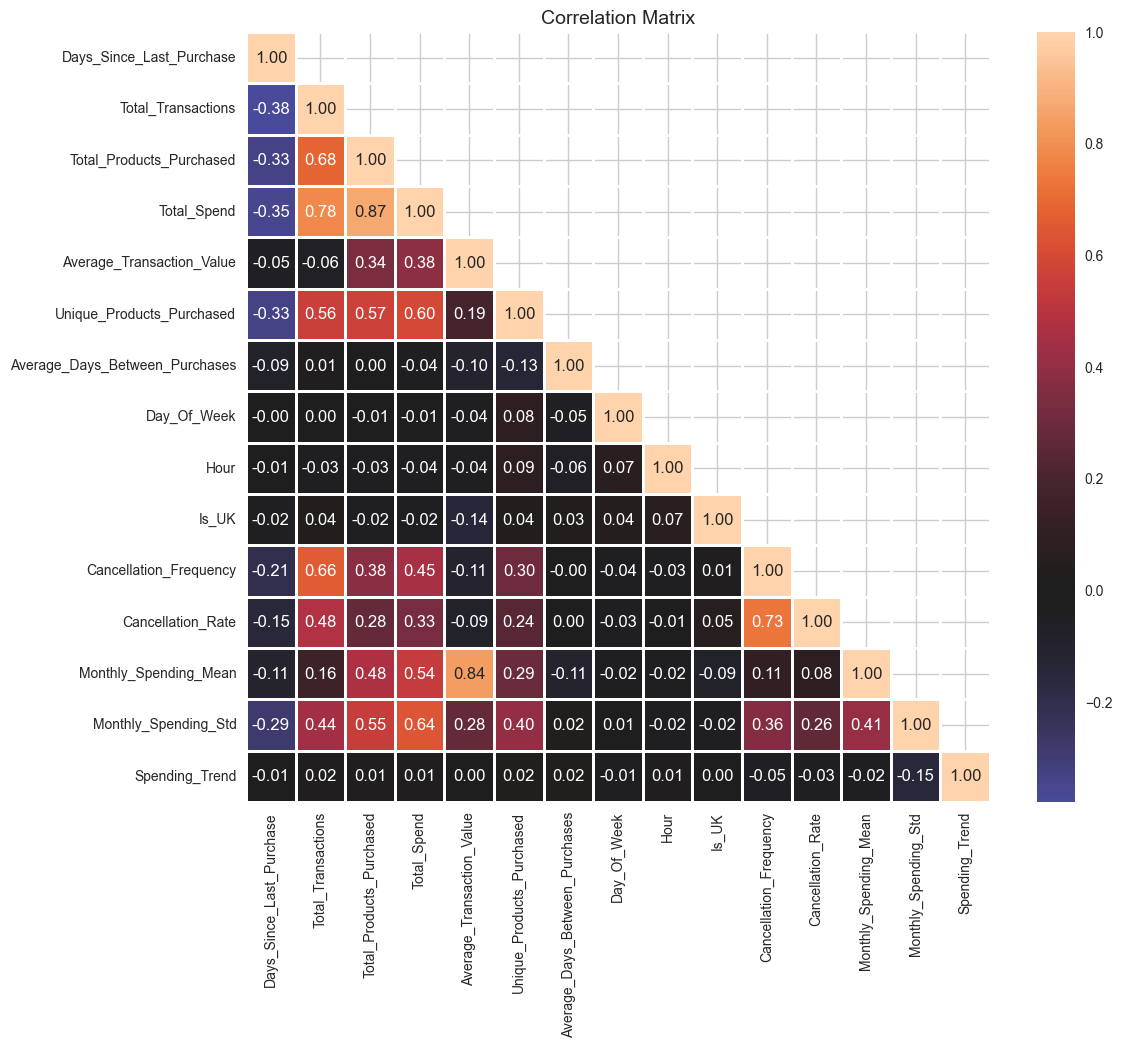

In [73]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

# Feature Scalling

In [74]:

# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12347.0                 -0.908356            0.768179   
1    12348.0                 -0.168895            0.011457   
2    12349.0                 -0.746282           -0.745265   
3    12350.0                  2.211560           -0.745265   
4    12352.0                 -0.563949            1.020419   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                  2.155062     2.509510                   1.467831   
1                  2.003206     0.257431                   0.299521   
2                 -0.048061     0.273353                   5.303668   
3                 -0.571123    -0.638490                   0.003757   
4                 -0.173403     0.217058                  -0.548413   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                   0.801581                       -0.127004            1   
1                  -0.568273                        0.703534            3   
2                   0.283709                       -0.315867            0   
3                  -0.651800                       -0.315867            2   
4                   0.033127                       -0.022489            1   

       Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0  0.644383      0               -0.533001          -0.426381   
1  2.812124      0               -0.533001          -0.426381   
2 -1.523359      0               -0.533001          -0.426381   
3  1.511479      0               -0.533001          -0.426381   
4  0.644383      0                0.415259          -0.223097   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0               0.877886              1.272642        0.113687  
1              -0.021004              0.474478       -0.485314  
2               3.829153             -0.711616        0.088185  
3              -0.248563             -0.711616        0.088185  
4              -0.066141             -0.013243        0.072938

In [75]:
customer_data_scaled.shape

(4051, 16)

In [76]:
#customer_data_scaled.to_csv("data/data_scaled.csv",index=False)

# PCA

In [77]:
# Setting CustomerID as the index column

# Apply PCA
pca = PCA().fit(customer_data_scaled)

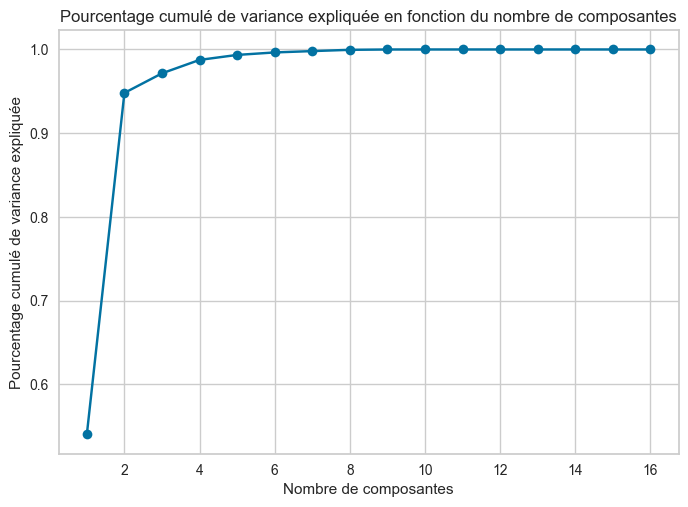

In [78]:

# Initialisation de PCA
pca = PCA()
customer_data_scaled.set_index('CustomerID', inplace=True)

# Ajuster PCA à vos données
pca.fit(customer_data_cleaned)

# Calculer le pourcentage cumulé de variance expliquée
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Tracer le graphique du pourcentage cumulé de variance expliquée
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Pourcentage cumulé de variance expliquée')
plt.title('Pourcentage cumulé de variance expliquée en fonction du nombre de composantes')
plt.grid(True)
plt.show()

In [79]:
# Creating a PCA object with x components
pca = PCA(n_components=4)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [80]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

PC1       PC2       PC3       PC4
CustomerID                                        
12347.0     3.367212 -1.467409  1.851261  0.980505
12348.0     0.677623  0.552042  0.632082  0.565799
12349.0     1.547134 -2.783422  5.563590 -0.408675
12350.0    -2.036070 -0.519467  0.548506 -1.122281
12352.0     0.511865 -1.490578 -0.758806  0.310971

In [81]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)


# le 1ere model : K-means
## Recherche du nombre optimal de clusters 

Pour déterminer le nombre optimal de clusters (k) pour segmenter les clients, nous avons explorerai deux méthodes renommées :

 - Méthode du Coude (Elbow Method)
 - Méthode de la Silhouette (Silhouette Method)

## En utulisant la méthode d' Elbow 
La méthode d'Elbow est une technique pour déterminer le nombre optimal de clusters dans un ensemble de données. 
### Par k-means
En utilisant l'algorithme K-means, elle calcule l'inertie (ou score WCSS) pour différentes valeurs de k et trace ces scores sur un graphique. Le point où le graphique forme un "coude" indique le nombre optimal de clusters, où l'augmentation de k n'améliore plus significativement l'inertie.   
> D'après le graphe, on constate que le nombre de clusters est 4

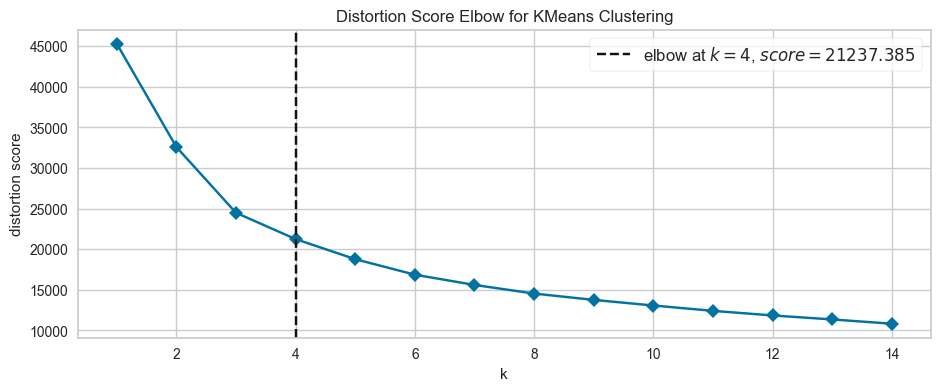

In [82]:
# Instancier le modèle de clustering avec les paramètres spécifiés
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=42)
fig, ax = plt.subplots(figsize=(11, 4))

# Instancier KElbowVisualizer
visualizer = KElbowVisualizer(km, k=(1, 15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)
visualizer.show();

In [83]:
import matplotlib.gridspec as gridspec

def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

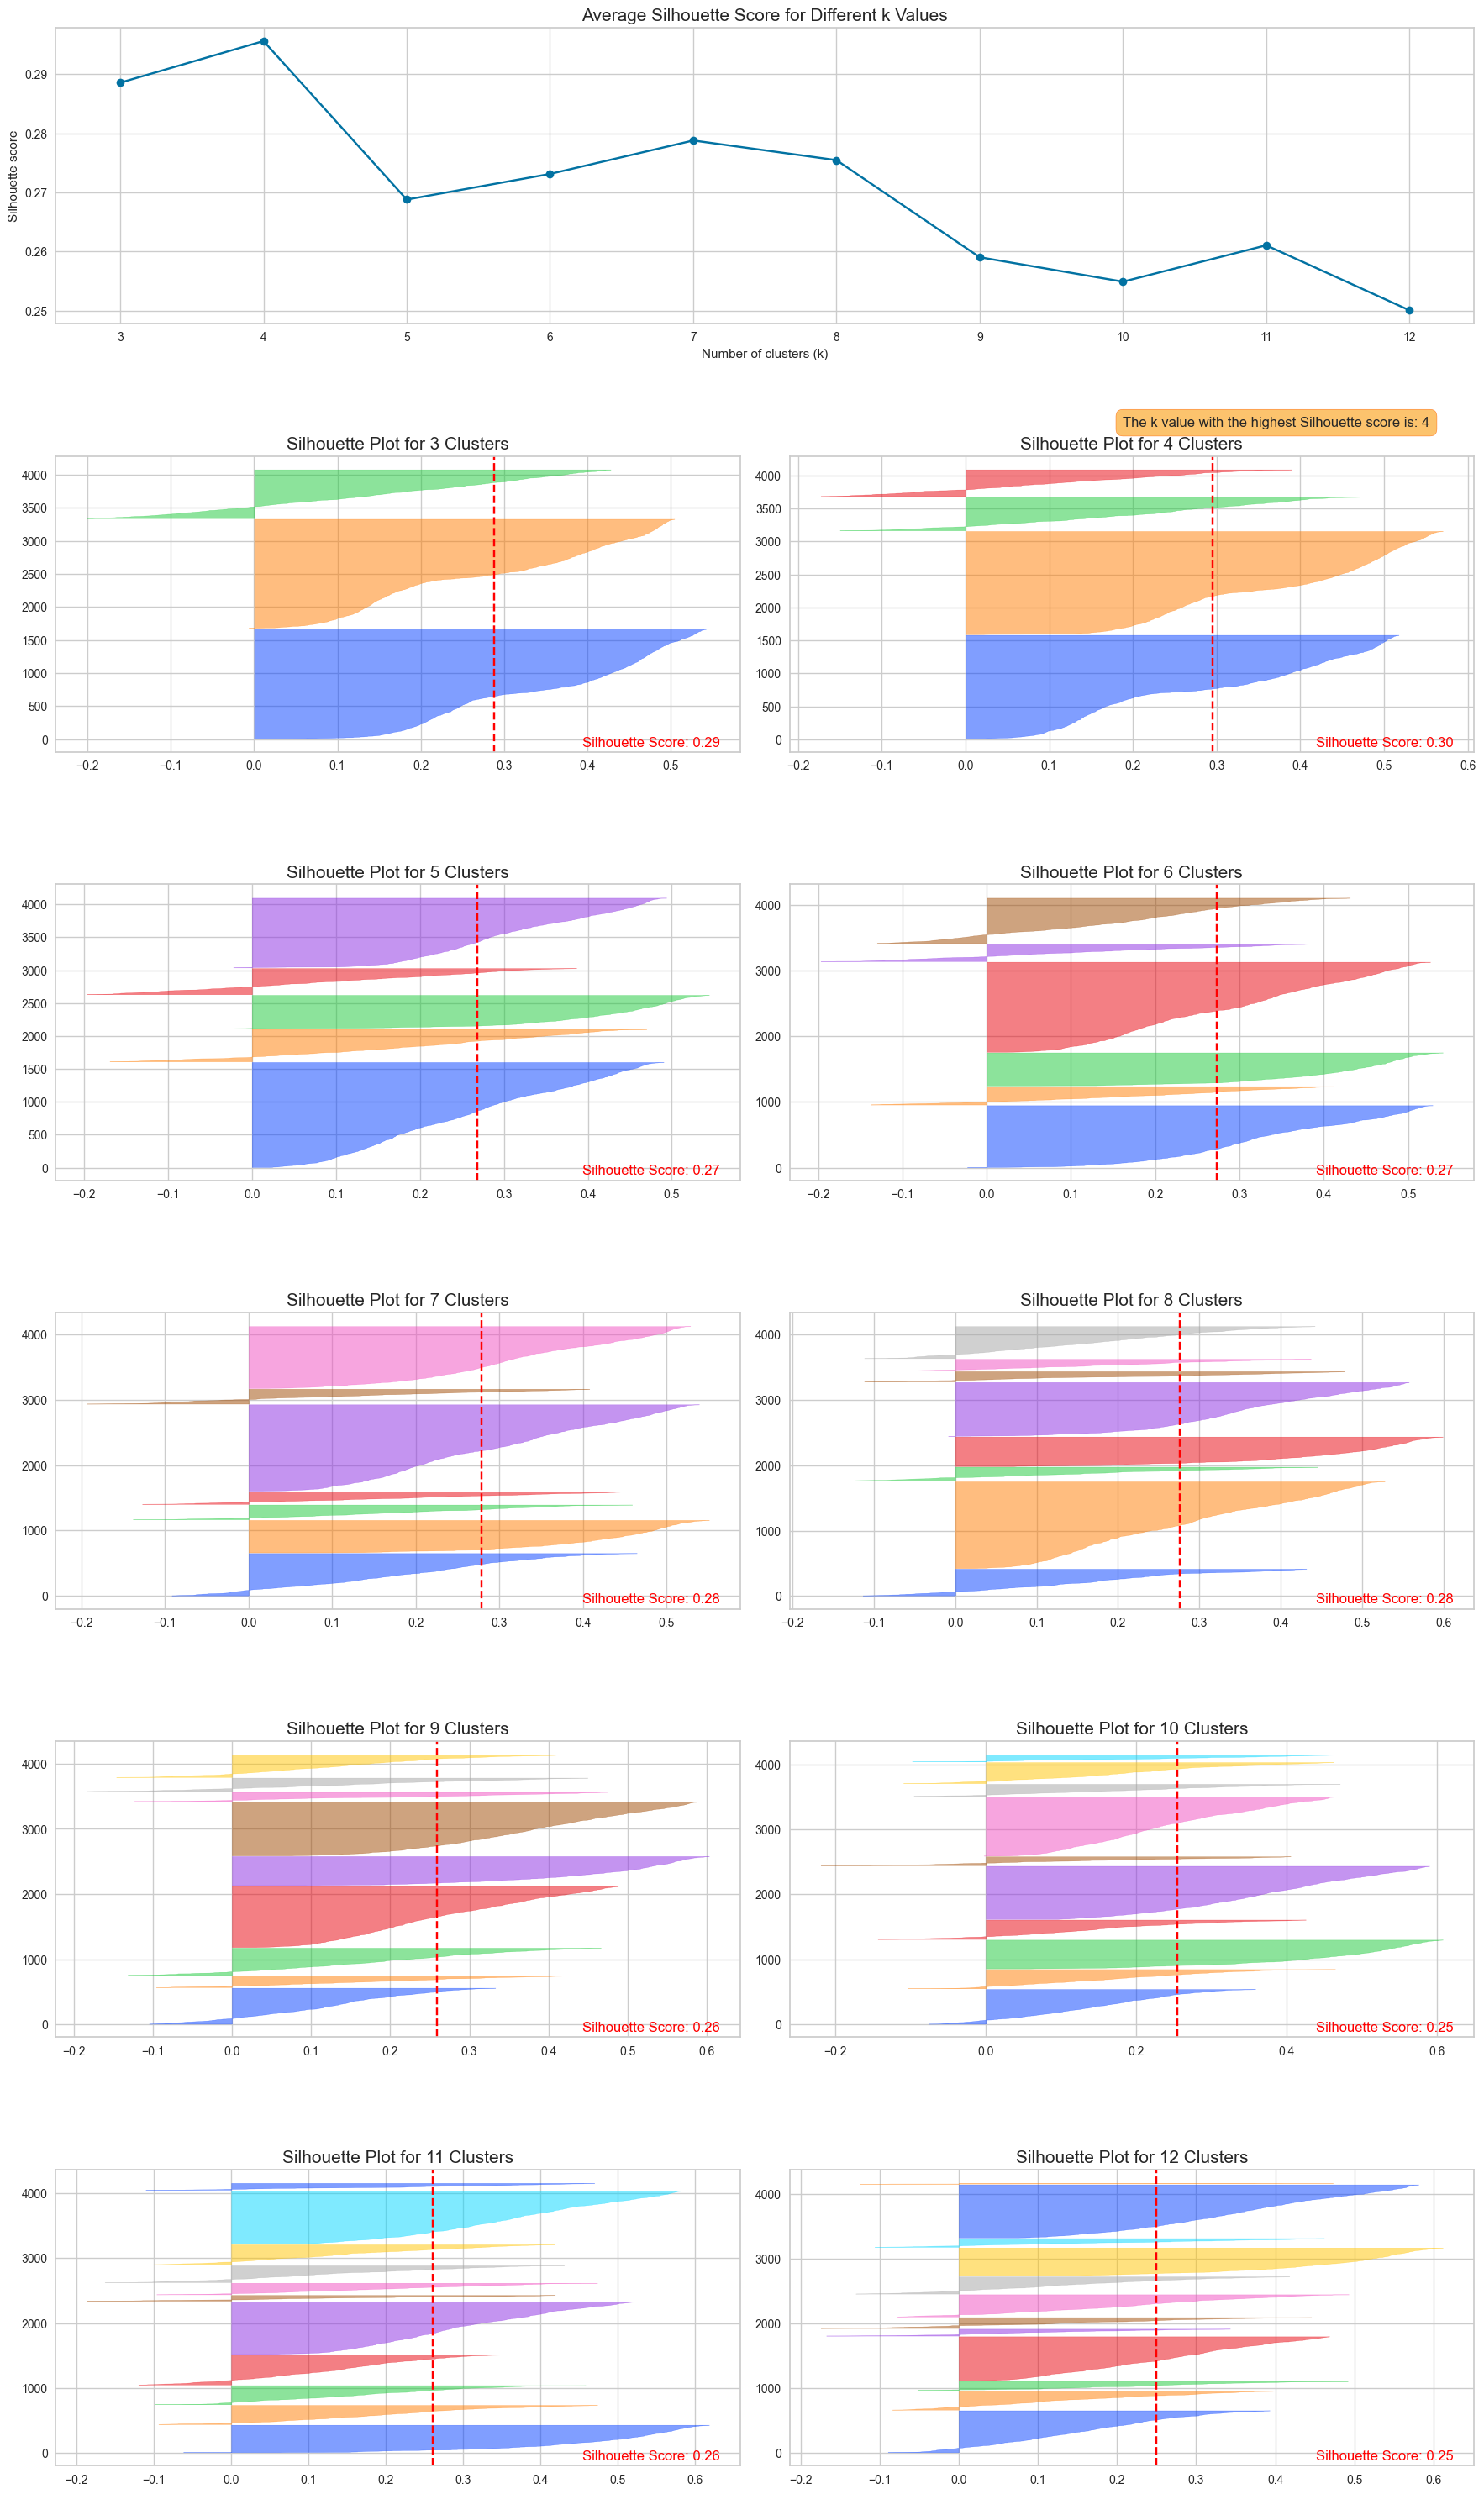

In [84]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(18, 50))

In [85]:
from sklearn.model_selection import GridSearchCV
customer_data_pca_kmeans= customer_data_pca.copy()

# Paramètres à tester
param_grid = {
    'init': ['k-means++', 'random'],  # Méthode d'initialisation des médoides
    'max_iter': [100, 200, 300],  # Nombre maximum d'itérations
    'random_state': [0,42,41]  # Graine aléatoire pour la reproductibilité
}
# Créer l'estimateur K-Medoids
kmeans = KMeans()

# Recherche sur la grille
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring='accuracy')
grid_search.fit(customer_data_pca_kmeans)

# Meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

# Meilleur modèle de clustering
best_model = grid_search.best_estimator_

# Effectuer le clustering avec les meilleurs hyperparamètres
clusters = best_model.fit_predict(customer_data_pca_kmeans)

Meilleurs hyperparamètres : {'init': 'k-means++', 'max_iter': 100, 'random_state': 0}


In [86]:
# Créer une copie de customer_data_pca pour stocker les données après clustering
customer_data_pca_kmeans = customer_data_pca.copy()
customer_data_cleaned_kmeans=customer_data_cleaned.copy()

# Appliquer KMeans clustering sur le nouveau DataFrame
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca_kmeans)
new_labels = kmeans.labels_

# Ajouter les nouvelles étiquettes de cluster à la copie du DataFrame
customer_data_pca_kmeans['cluster'] = new_labels
customer_data_cleaned_kmeans['cluster'] = new_labels


In [87]:
customer_data_pca_kmeans.head(4)

PC1       PC2       PC3       PC4  cluster
CustomerID                                                 
12347.0     3.367212 -1.467409  1.851261  0.980505        3
12348.0     0.677623  0.552042  0.632082  0.565799        0
12349.0     1.547134 -2.783422  5.563590 -0.408675        3
12350.0    -2.036070 -0.519467  0.548506 -1.122281        1

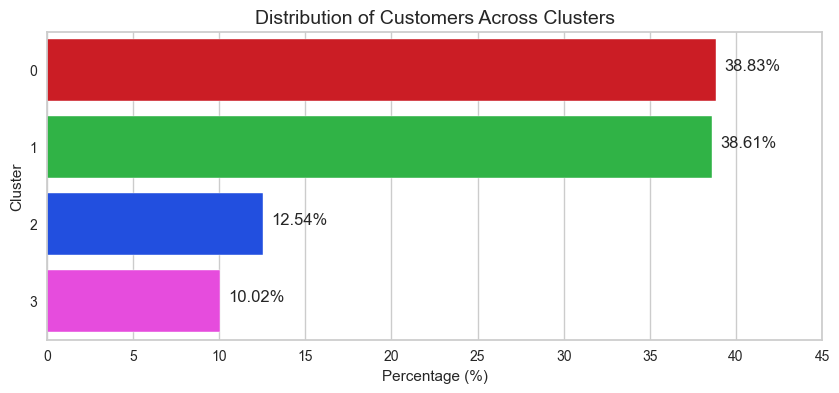

In [88]:
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3','#9467bd']

cluster_percentage = (customer_data_pca_kmeans['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

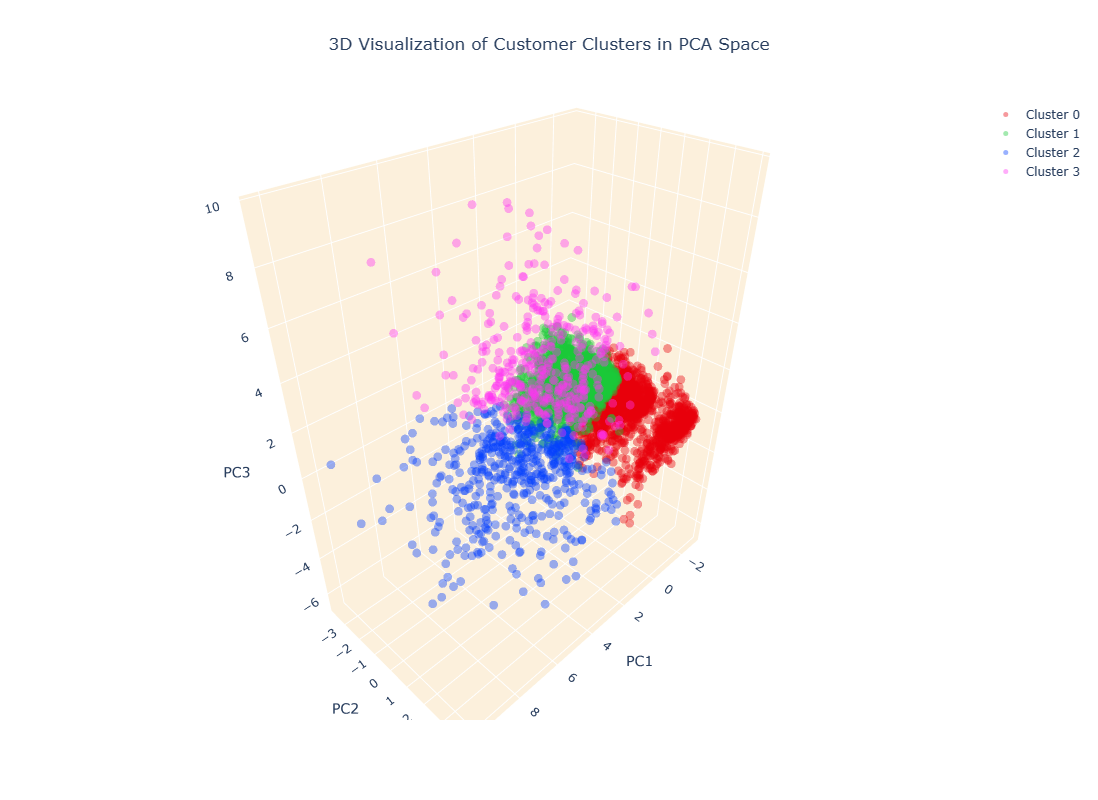

In [89]:
import plotly.graph_objects as go

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca_kmeans['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca_kmeans['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca_kmeans['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca_kmeans['cluster'] == 3]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

## Size pour chaque cluster dams k-means model

In [90]:
kmeans_clust_size = customer_data_pca_kmeans.groupby('cluster').size().to_frame()
kmeans_clust_size.columns=['kmenas-size']
kmeans_clust_size

kmenas-size
cluster             
0               1573
1               1564
2                508
3                406

In [91]:
customer_data_cleaned_kmeans.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12347.0                         2                   7   
1    12348.0                        75                   4   
2    12349.0                        18                   1   
3    12350.0                       310                   1   
4    12352.0                        36                   8   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                      2458       4310.0                 615.714286   
1                      2332      1437.24                     359.31   
2                       630      1457.55                    1457.55   
3                       196        294.4                      294.4   
4                       526      1385.74                   173.2175   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                        103                        2.016575            1   
1                         21                       10.884615            3   
2                         72                             0.0            0   
3                         16                             0.0            2   
4                         57                         3.13253            1   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    14      0                       0                0.0   
1    19      0                       0                0.0   
2     9      0                       0                0.0   
3    16      0                       0                0.0   
4    14      0                       1              0.125   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  cluster  
0             615.714286            341.070789        4.486071        3  
1                 359.31            203.875689        -100.884        0  
2                1457.55                   0.0             0.0        3  
3                  294.4                   0.0             0.0        1  
4                346.435            120.042154          -2.682        1

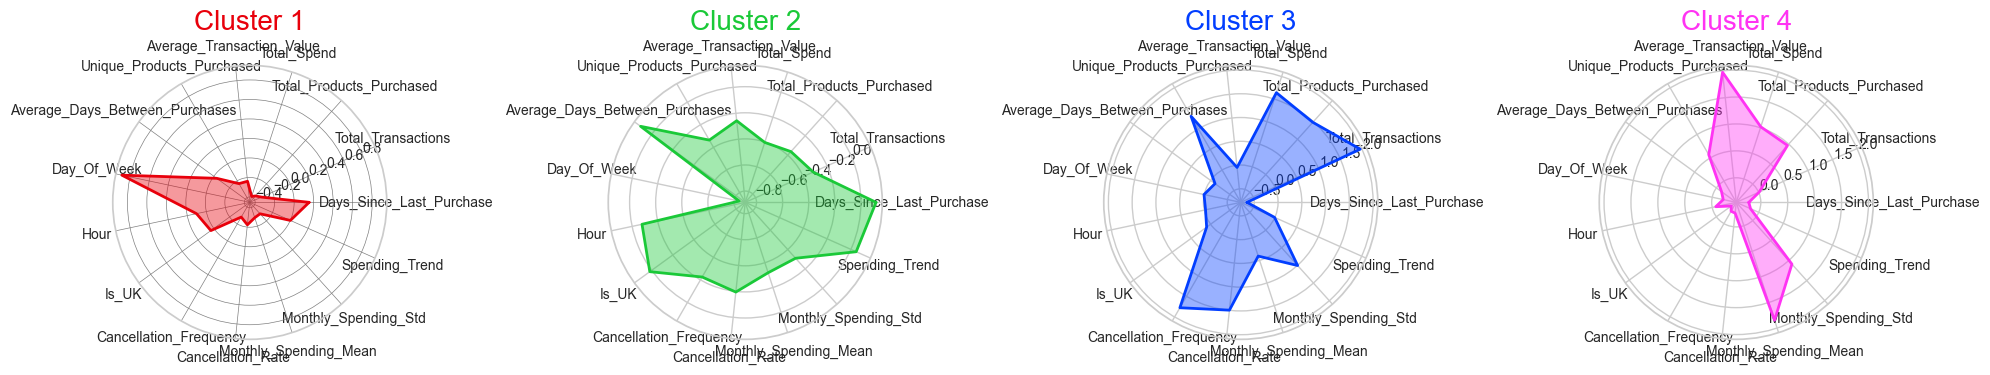

In [92]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned_kmeans.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Define colors for each cluster
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3']

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=4)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i+1)

# Add input data
for i in range(4):
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

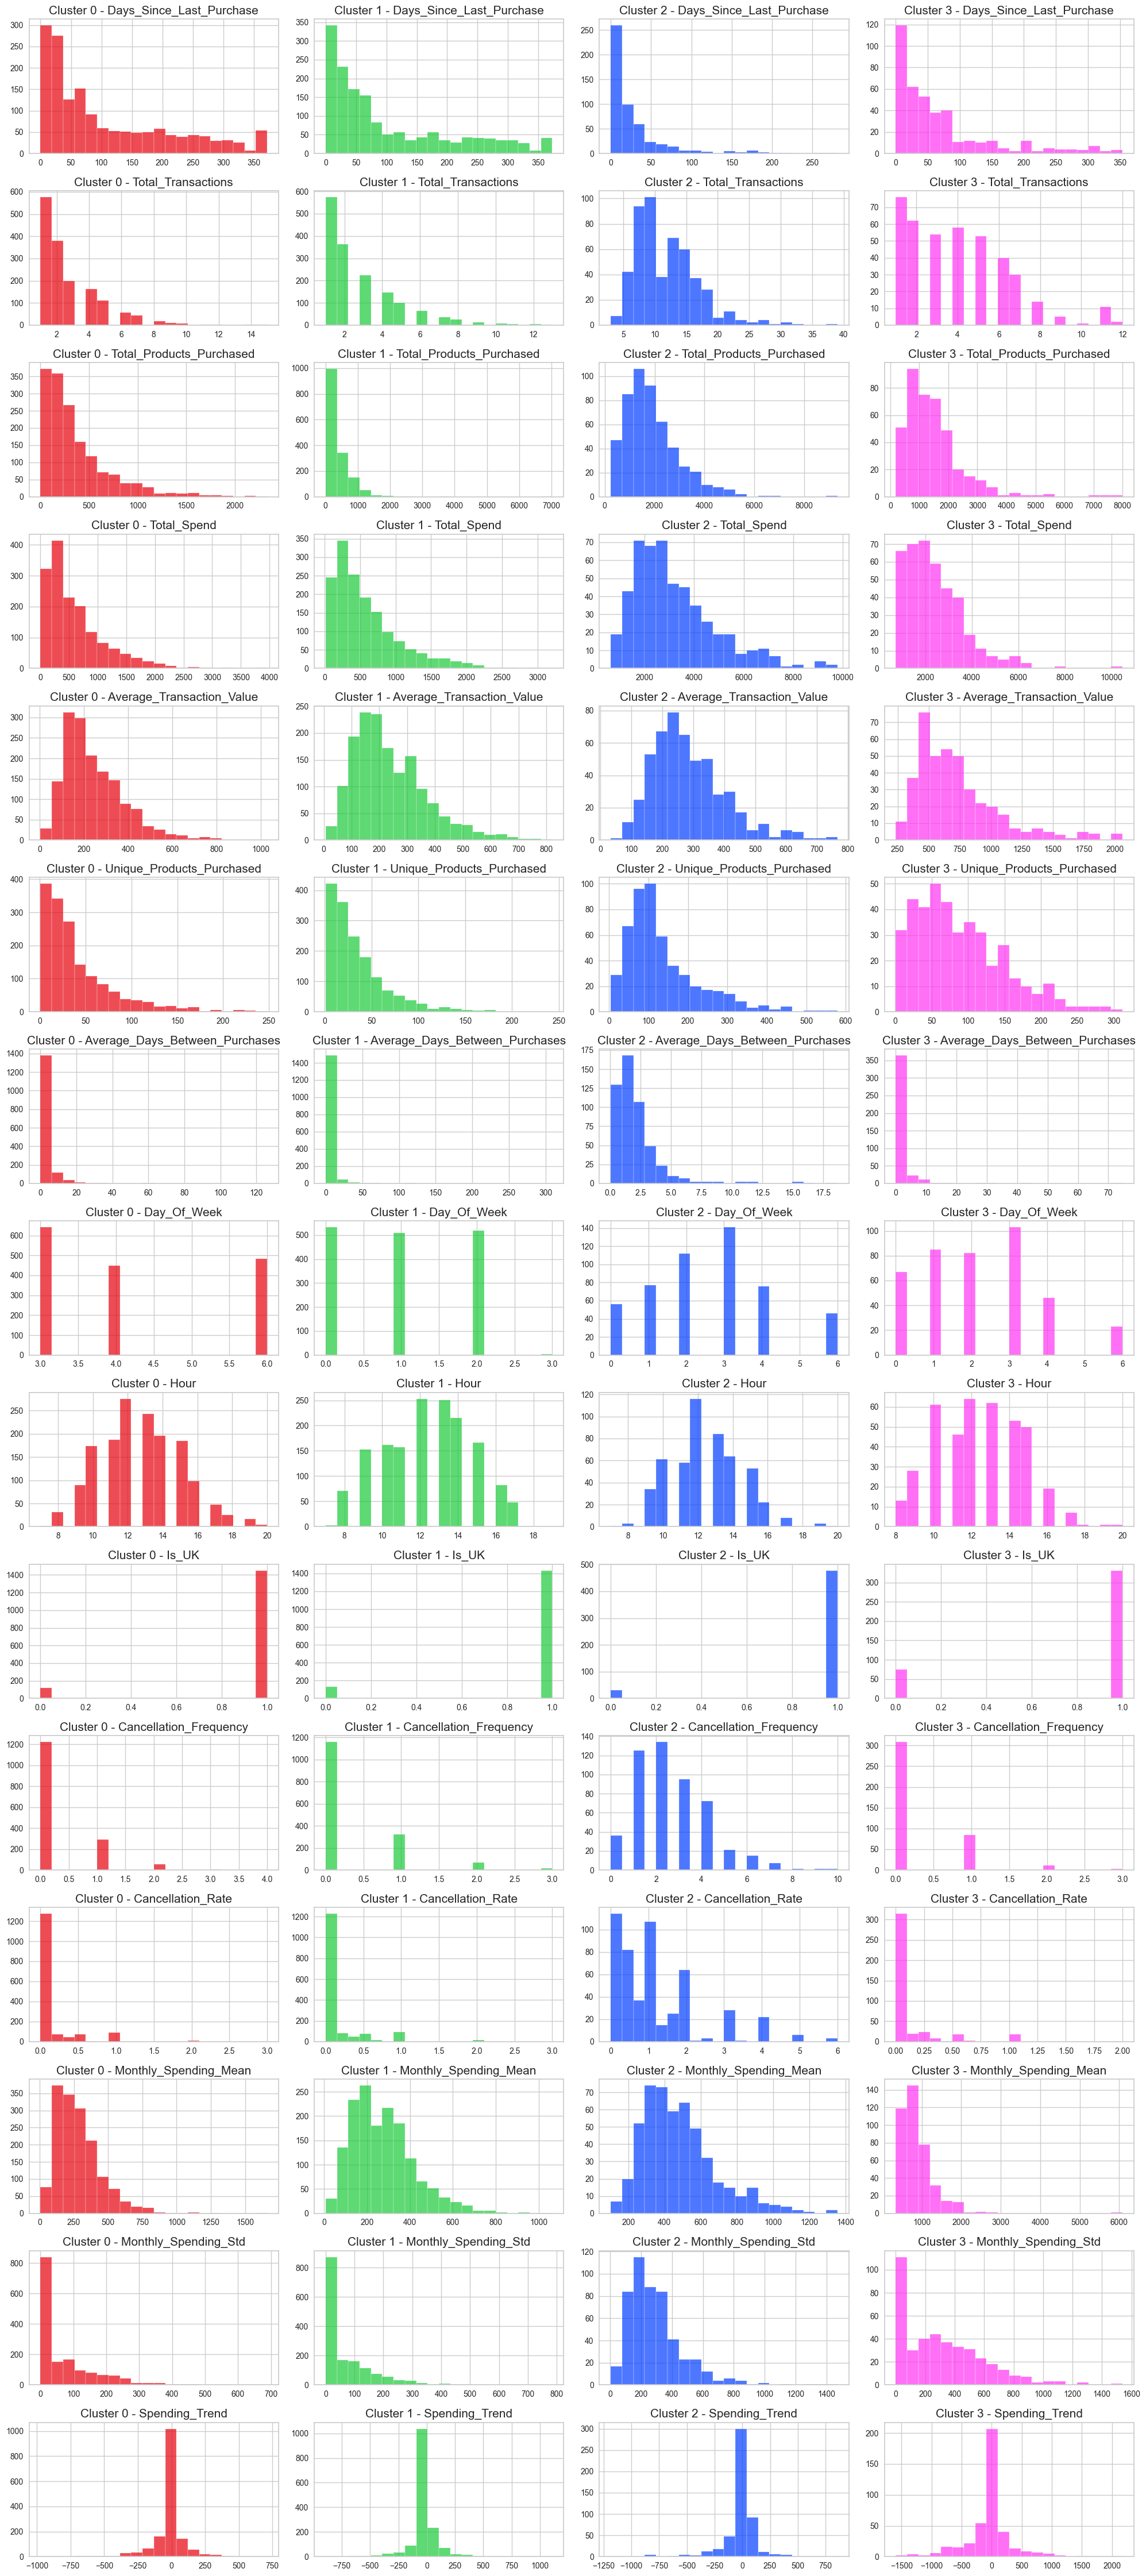

In [93]:
features = customer_data_cleaned_kmeans.columns[1:-1]
clusters = customer_data_cleaned_kmeans['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned_kmeans[customer_data_cleaned_kmeans['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# Clustring Agglomerative 

In [94]:
customer_data_pca.head(3)

PC1       PC2       PC3       PC4
CustomerID                                        
12347.0     3.367212 -1.467409  1.851261  0.980505
12348.0     0.677623  0.552042  0.632082  0.565799
12349.0     1.547134 -2.783422  5.563590 -0.408675

In [95]:
customer_data_cleaned.head(3)

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12347.0                         2                   7   
1    12348.0                        75                   4   
2    12349.0                        18                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                      2458       4310.0                 615.714286   
1                      2332      1437.24                     359.31   
2                       630      1457.55                    1457.55   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                        103                        2.016575            1   
1                         21                       10.884615            3   
2                         72                             0.0            0   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    14      0                       0                0.0   
1    19      0                       0                0.0   
2     9      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0             615.714286            341.070789        4.486071  
1                 359.31            203.875689        -100.884  
2                1457.55                   0.0             0.0

In [101]:
from sklearn.metrics import make_scorer
customer_data_pca_agg= customer_data_pca.copy()
customer_data_cleaned_agg=customer_data_cleaned.copy()
# Create the AgglomerativeClustering estimator
estimator = AgglomerativeClustering()
scoring = make_scorer(silhouette_score)

# Define the parameter grid
param_grid = {
    'linkage': ['ward', 'complete', 'average'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Create the GridSearchCV with scoring metric
grid_search = GridSearchCV(estimator, param_grid,scoring=scoring)

# Fit the model with GridSearchCV
grid_search.fit(customer_data_pca_agg) 

# Get the best parameters and best score
best_params = grid_search.best_params_

# Print the results
print("Best Parameters:", best_params)


Best Parameters: {'linkage': 'ward', 'metric': 'euclidean'}


In [102]:
# Créer une copie de customer_data_pca , customer_data_cleaned pour stocker les données après clustering
agglomer=AgglomerativeClustering(n_clusters=4,linkage='ward',metric='euclidean').fit(customer_data_pca_agg)
customer_data_pca_agg['cluster']=agglomer.labels_
customer_data_cleaned_agg['cluster']=agglomer.labels_

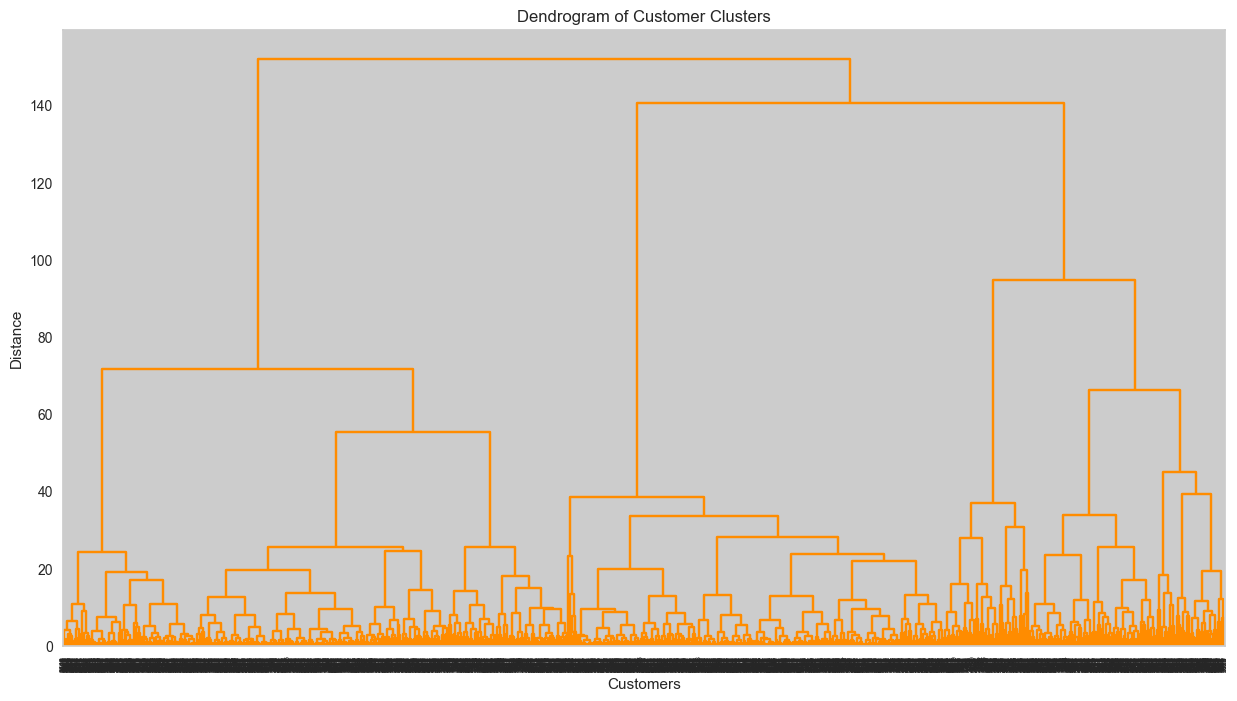

In [103]:
# Compute the linkage matrix
Z = linkage(customer_data_pca_agg, method='ward', metric='euclidean')
# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title('Dendrogram of Customer Clusters')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

## Size de  cluster pour modele clustring agglomerative


In [116]:
agg_clust_size = customer_data_pca_agg.groupby('cluster').size().to_frame()
agg_clust_size.columns=['agg-size']
agg_clust_size

agg-size
cluster          
0            1762
1             683
2            1310
3             296

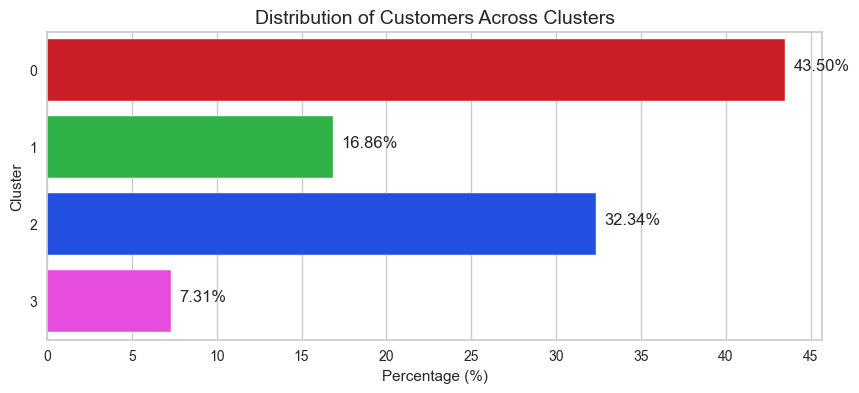

In [117]:
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3','#9467bd']

cluster_percentage = (customer_data_pca_agg['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

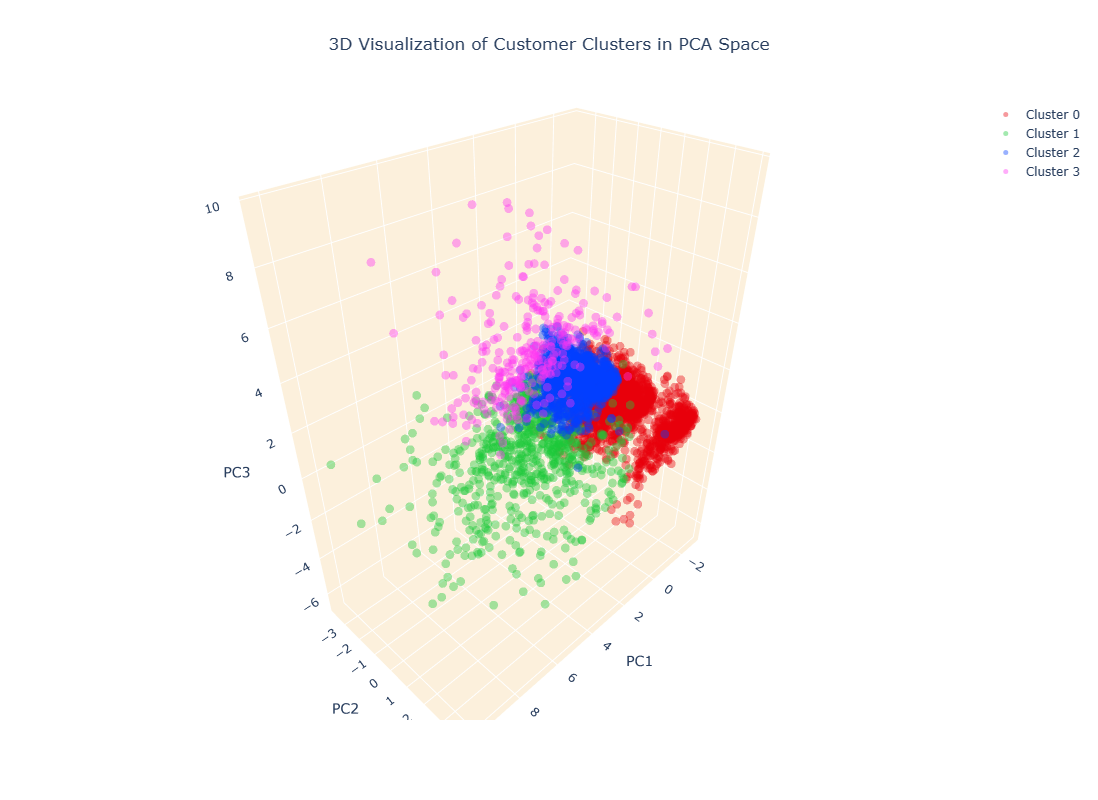

In [118]:
import plotly.graph_objects as go

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca_agg['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca_agg['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca_agg['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca_agg['cluster'] == 3]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))


# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

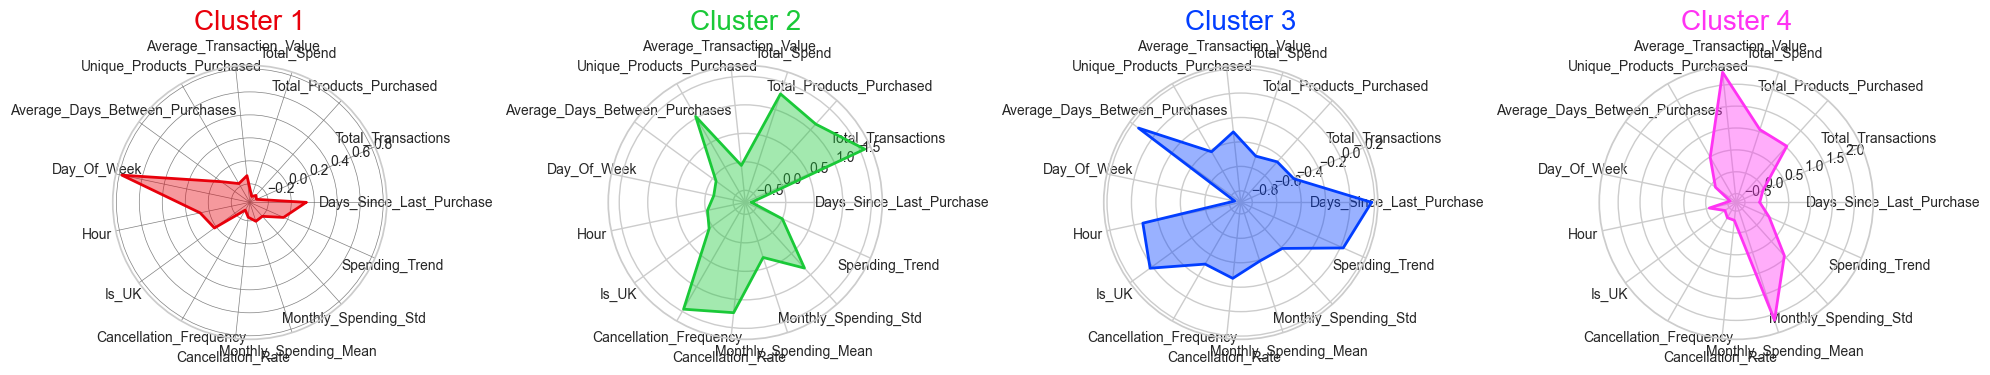

In [119]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned_agg.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Define colors for each cluster
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3']

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=4)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i+1)

# Add input data
for i in range(4):
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

# Kmedois 

In [124]:
customer_data_pca_kmedois= customer_data_pca.copy()

# Paramètres à tester
param_grid = {
    'init': ['k-medoids++', 'random'],  # Méthode d'initialisation des médoides
    'max_iter': [100, 200, 300],  # Nombre maximum d'itérations
    'random_state': [0,42,41]  # Graine aléatoire pour la reproductibilité
}
# Créer l'estimateur K-Medoids
kmedoids = KMedoids()

# Recherche sur la grille
grid_search = GridSearchCV(estimator=kmedoids, param_grid=param_grid, scoring='accuracy')
grid_search.fit(customer_data_pca_kmedois)

# Meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

# Meilleur modèle de clustering
best_model = grid_search.best_estimator_

# Effectuer le clustering avec les meilleurs hyperparamètres
clusters = best_model.fit_predict(customer_data_pca_kmedois)

Meilleurs hyperparamètres : {'init': 'k-medoids++', 'max_iter': 100, 'random_state': 0}


In [125]:
customer_data_pca_kmedois= customer_data_pca.copy()
customer_data_cleaned_kmedois=customer_data_cleaned.copy()

kmedois =KMedoids(n_clusters=4,init="k-medoids++",max_iter=100,random_state=0).fit(customer_data_pca_kmedois)
customer_data_pca_kmedois['cluster']=kmedois.labels_
customer_data_cleaned_kmedois['cluster']=kmedois.labels_

In [126]:
kmedois_clust_size = customer_data_pca_kmedois.groupby('cluster').size().to_frame()
kmedois_clust_size.columns=['kmedois-size']
kmedois_clust_size

kmedois-size
cluster              
0                1247
1                 876
2                1427
3                 501

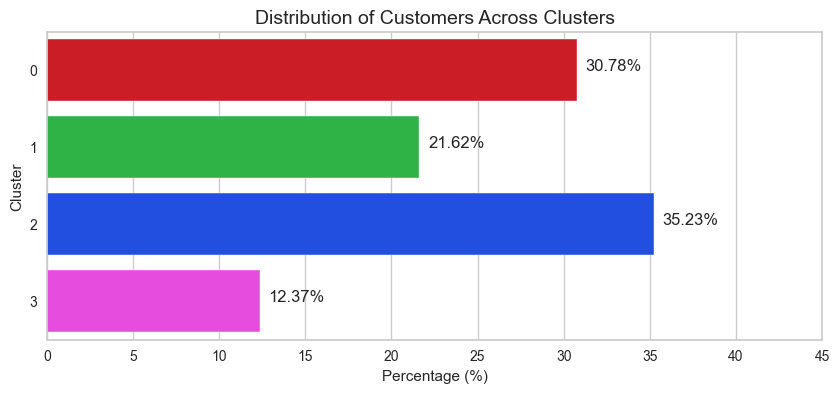

In [127]:
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3','#9467bd']

cluster_percentage = (customer_data_pca_kmedois['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# Mean shift

In [128]:
from sklearn.cluster import MeanShift

customer_data_pca_meanShift= customer_data_pca.copy()
customer_data_cleaned_meanShift=customer_data_cleaned.copy()

# Création de l'objet MeanShift
meanshift = MeanShift()

# Entraînement du modèle
meanshift.fit(customer_data_pca_meanShift)

# Obtention des labels de cluster assignés à chaque échantillon
labels = meanshift.labels_

# Obtention des centres de cluster
cluster_centers = meanshift.cluster_centers_

# Obtention du nombre de clusters
n_clusters = len(cluster_centers)
n_clusters

5

In [129]:
customer_data_pca_meanShift['cluster']=meanshift.labels_
customer_data_cleaned_meanShift['cluster']=meanshift.labels_

In [130]:
meanshift_clust_size = customer_data_pca_meanShift.groupby('cluster').size().to_frame()
meanshift_clust_size.columns=['meanShift-size']
meanshift_clust_size

meanShift-size
cluster                
0                  3984
1                     2
2                    11
3                    48
4                     6

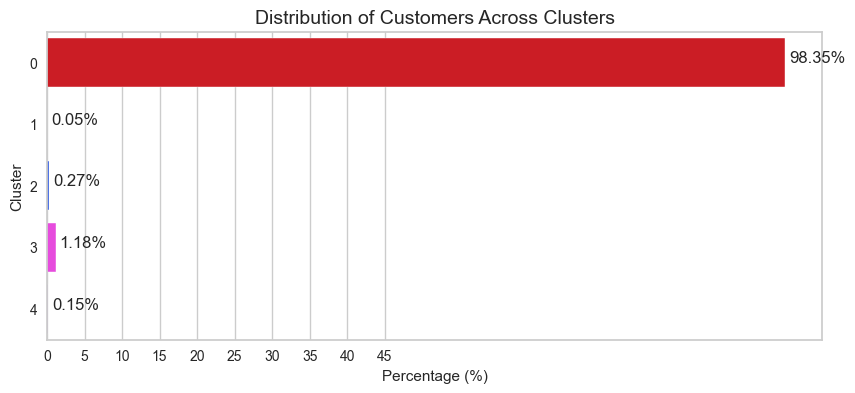

In [131]:
colors = ['#e8000b', '#1ac938', '#023eff','#FF33F3','#9467bd']

cluster_percentage = (customer_data_pca_meanShift['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# Comparaison entre les models

## d 'apres le nombre de chaque cluster dans chaque models

In [132]:
clusters=pd.concat([agg_clust_size,kmeans_clust_size,meanshift_clust_size,kmedois_clust_size],axis=1,sort=False)
clusters

agg-size  kmenas-size  meanShift-size  kmedois-size
cluster                                                     
0          1762.0       1573.0            3984        1247.0
1           683.0       1564.0               2         876.0
2          1310.0        508.0              11        1427.0
3           296.0        406.0              48         501.0
4             NaN          NaN               6           NaN

## d'appres les metriques 

In [159]:

# Calculate performance metrics for KMeans
X = customer_data_pca_kmeans.drop('cluster', axis=1)
kmeans_sil_score = silhouette_score(X, customer_data_pca_kmeans['cluster'])
kmeans_calinski_score = calinski_harabasz_score(X, customer_data_pca_kmeans['cluster'])
kmeans_davies_score = davies_bouldin_score(X, customer_data_pca_kmeans['cluster'])

# Calculate performance metrics for Agglomerative Clustering
X = customer_data_pca_agg.drop('cluster', axis=1)
agg_sil_score = silhouette_score(X, customer_data_pca_agg['cluster'])
agg_calinski_score = calinski_harabasz_score(X, customer_data_pca_agg['cluster'])
agg_davies_score = davies_bouldin_score(X, customer_data_pca_agg['cluster'])

# Calculate performance metrics for Kmedois
X = customer_data_pca_kmedois.drop('cluster', axis=1)
kmedois_sil_score = silhouette_score(X, customer_data_pca_kmedois['cluster'])
kmedois_calinski_score = calinski_harabasz_score(X, customer_data_pca_kmedois['cluster'])
kmedois_davies_score = davies_bouldin_score(X, customer_data_pca_kmedois['cluster'])


# Calculate performance metrics for MeanShift
X = customer_data_pca_meanShift.drop('cluster', axis=1)
meanshift_sil_score = silhouette_score(X, customer_data_pca_meanShift['cluster'])
meanshift_calinski_score = calinski_harabasz_score(X, customer_data_pca_meanShift['cluster'])
meanshift_davies_score = davies_bouldin_score(X, customer_data_pca_meanShift['cluster'])



# Create a list of models and their scores
models = [
    ["KMeans", kmeans_sil_score, kmeans_calinski_score, kmeans_davies_score],
    ["Agglomerative Clustering", agg_sil_score, agg_calinski_score, agg_davies_score],
    ["Kmedois", kmedois_sil_score, kmedois_calinski_score, kmedois_davies_score],
    ["MeanShift", kmedois_sil_score, meanshift_calinski_score, meanshift_davies_score],

]

# Print the table
print(tabulate(models, headers=["Model", "Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"], tablefmt='pretty'))

# Find the best model based on the average score
best_model = None
best_score = float('-inf')

for model in models:
    average_score = sum(model[1:]) / len(model[1:])
    if average_score > best_score:
        best_score = average_score
        best_model = model[0]

# Print the best model
print(f"Best model : {best_model}")

+--------------------------+--------------------+-------------------------+----------------------+
|          Model           |  Silhouette Score  | Calinski Harabasz Score | Davies Bouldin Score |
+--------------------------+--------------------+-------------------------+----------------------+
|          KMeans          | 0.2955876700858404 |    1527.878481203664    |  1.243982622586119   |
| Agglomerative Clustering | 0.2504723949360417 |   1235.1478048610418    |  1.3181359049211918  |
|         Kmedois          | 0.2449089851158853 |   1364.4135696453454    |  1.4609717574611787  |
|        MeanShift         | 0.2449089851158853 |    95.56921885995067    |  1.2569936744620762  |
+--------------------------+--------------------+-------------------------+----------------------+
Best model : KMeans


Une valeur de coefficient de silhouette plus proche de 1 indique une meilleure séparation entre les clusters. c'est Kmeans

In [133]:
#after all this analytics  we conclure that our dataset contiens:
label_mapping = {}
# Parcourir chaque label et lui assigner un nouveau label en fonction de vos critères
for label in kmeans.labels_:
    if label == 0:
        new_label = "Monthly High-Spenders"
    elif label == 1:
        new_label = "Occasional High-Spenders"
    elif label == 2:
        new_label = "High-Spending Churn Risk"
    elif label == 3:
        new_label = "Low-Spending Weekend Shoppers"
    else:
        new_label = "Unknown"  # Si jamais un label inattendu est rencontré
    
    # Ajouter l'ancien label et son nouveau label correspondant au mapping
    label_mapping[label] = new_label

# Appliquer le mapping pour obtenir les nouveaux labels de cluster
new_labels = [label_mapping[label] for label in kmeans.labels_]

# Ajouter les nouveaux labels au jeu de données
customer_data_cleaned['cluster'] = new_labels

customer_data_cleaned.tail(4)

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
4047    18281.0                       180                   1   
4048    18282.0                         7                   3   
4049    18283.0                         3                  16   
4050    18287.0                        42                   3   

      Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
4047                        54        80.82                      80.82   
4048                       103       178.05                      59.35   
4049                      1355      2039.58                  127.47375   
4050                      1586      1837.28                 612.426667   

      Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
4047                          7                             0.0            6   
4048                         12                        9.916667            4   
4049                        262                        0.465181            3   
4050                         59                        2.304348            2   

      Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
4047    10      1                       0                0.0   
4048    13      1                       1               0.25   
4049    14      1                       0                0.0   
4050    10      1                       0                0.0   

      Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
4047                  80.82                   0.0             0.0   
4048                 89.025             15.817979          -22.37   
4049                203.958            165.798738       22.319273   
4050                 918.64            216.883792          306.72   

                            cluster  
4047          Monthly High-Spenders  
4048          Monthly High-Spenders  
4049       High-Spending Churn Risk  
4050  Low-Spending Weekend Shoppers

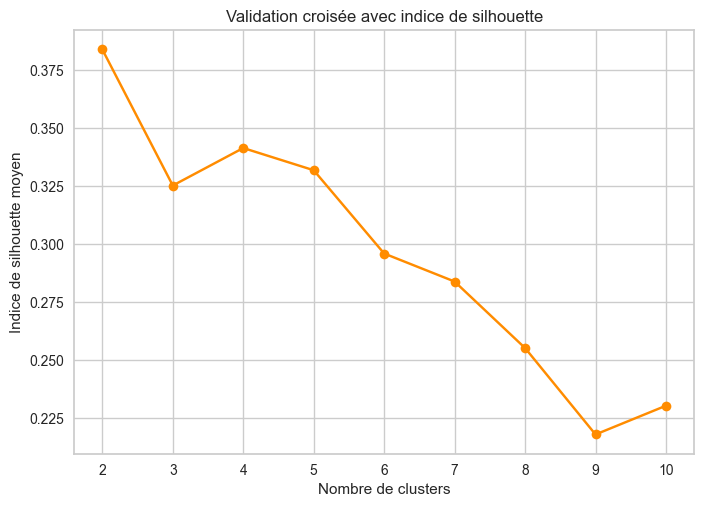

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test = train_test_split(customer_data_pca_kmeans,test_size=0.2, random_state=0)

# Liste pour stocker les valeurs de l'indice de silhouette moyen
silhouette_scores = []

# Tester différents nombres de clusters
for k in range(2, 11):  # Tester de 2 à 10 clusters
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(X_train)
    labels = model.predict(X_test)
    silhouette_avg = silhouette_score(X_test, labels)
    silhouette_scores.append(silhouette_avg)

# Tracer le graphique de l'indice de silhouette en fonction du nombre de clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de silhouette moyen')
plt.title('Validation croisée avec indice de silhouette')
plt.show()


# Systeme du recomendation

In [136]:
customer_data_cleaned_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4051 entries, 0 to 4050
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4051 non-null   string 
 1   Days_Since_Last_Purchase        4051 non-null   Int64  
 2   Total_Transactions              4051 non-null   Int64  
 3   Total_Products_Purchased        4051 non-null   Int64  
 4   Total_Spend                     4051 non-null   Float64
 5   Average_Transaction_Value       4051 non-null   Float64
 6   Unique_Products_Purchased       4051 non-null   Int64  
 7   Average_Days_Between_Purchases  4051 non-null   Float64
 8   Day_Of_Week                     4051 non-null   Int32  
 9   Hour                            4051 non-null   Int32  
 10  Is_UK                           4051 non-null   Int64  
 11  Cancellation_Frequency          4051 non-null   Int64  
 12  Cancellation_Rate               40

In [105]:
data = pd.read_excel("data/Online-retail.xlsx")

In [107]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = data[~data['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned_kmeans['CustomerID'] = customer_data_cleaned_kmeans['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned_kmeans[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster

customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned_kmeans[customer_data_cleaned_kmeans['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned_kmeans.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')
customer_data_with_recommendations.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12362.0                         3                  13   
1     12395.0                        15                  15   
2     12408.0                        32                   8   
3     12417.0                         3                  12   
4     12431.0                        35                  18   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                      2180      4665.58                 358.890769   
1                      2092      2662.28                 177.485333   
2                      1382      2587.57                  323.44625   
3                      1514       3155.8                 262.983333   
4                      2839      6243.89                 346.882778   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                        200                        1.110266            3   
1                         90                        2.438356            4   
2                         80                        2.130841            4   
3                        157                        1.882979            3   
4                        162                        1.438298            3   

   Hour  ...  Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
0    15  ...               583.1975            393.992285       46.824048   
1    16  ...             295.808889             219.91505       18.175167   
2    10  ...                517.514            314.309603          44.543   
3    14  ...             350.644444            217.884282          0.3115   
4    14  ...             693.765556            351.562387       12.737167   

   cluster  Rec1_StockCode            Rec1_Description  Rec2_StockCode  \
0        0           22616  PACK OF 12 LONDON TISSUES            84077   
1        0           22616  PACK OF 12 LONDON TISSUES            84077   
2        0           22616  PACK OF 12 LONDON TISSUES            84077   
3        0           22616  PACK OF 12 LONDON TISSUES            84077   
4        0           22616  PACK OF 12 LONDON TISSUES            84077   

                    Rec2_Description Rec3_StockCode  \
0  WORLD WAR 2 GLIDERS ASSTD DESIGNS          22178   
1  WORLD WAR 2 GLIDERS ASSTD DESIGNS          22178   
2  WORLD WAR 2 GLIDERS ASSTD DESIGNS          22178   
3  WORLD WAR 2 GLIDERS ASSTD DESIGNS          22178   
4  WORLD WAR 2 GLIDERS ASSTD DESIGNS          22178   

                  Rec3_Description  
0  VICTORIAN GLASS HANGING T-LIGHT  
1  VICTORIAN GLASS HANGING T-LIGHT  
2  VICTORIAN GLASS HANGING T-LIGHT  
3  VICTORIAN GLASS HANGING T-LIGHT  
4  VICTORIAN GLASS HANGING T-LIGHT  

[5 rows x 23 columns]

In [108]:
customer_data_with_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4067 entries, 0 to 4066
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4067 non-null   float64
 1   Days_Since_Last_Purchase        4067 non-null   Int64  
 2   Total_Transactions              4067 non-null   Int64  
 3   Total_Products_Purchased        4067 non-null   Int64  
 4   Total_Spend                     4067 non-null   Float64
 5   Average_Transaction_Value       4067 non-null   Float64
 6   Unique_Products_Purchased       4067 non-null   Int64  
 7   Average_Days_Between_Purchases  4067 non-null   Float64
 8   Day_Of_Week                     4067 non-null   Int32  
 9   Hour                            4067 non-null   Int32  
 10  Is_UK                           4067 non-null   Int64  
 11  Cancellation_Frequency          4067 non-null   Int64  
 12  Cancellation_Rate               40

In [ ]:
customer_data_with_recommendations.to_csv("data/customer_data_with_recommendations.csv",index=False)

In [100]:
from joblib import dump
dump(kmeans,"data/K-means.pkl")

['data/K-means.pkl']

In [101]:
#pour notre application 
import pickle
from joblib import dump
dump(kmeans,"data/Kmeans.pkl")
def apply_pca(data, pca_components):
    """
    Apply PCA transformation to the input data
    Args:
        data (np.ndarray): Input data
        pca_components (np.ndarray): PCA transformation matrix
    Returns:
        np.ndarray: Principal component scores
    """
    return data @ pca_components.T

def get_prediction(model, pca_scores):
    """
    Use the trained model to make predictions on the PCA scores
    Args:
        model: Trained model
        pca_scores (np.ndarray): Principal component scores
    Returns:
        Prediction result
    """
    # Make predictions using the trained model
    predictions = model.predict(pca_scores)
    return predictions